In [ ]:
import keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Dense, Input
from tensorflow.keras.optimizers import Adam 
import numpy as np
import random
import pandas as pd
from matplotlib import pyplot as plt
import traceback
from IPython import display
from datetime import datetime, timedelta, time, date
import matplotlib.dates as mdates


from tensorflow.python.framework.ops import disable_eager_execution
import statistics


In [ ]:
#disable_eager_execution()
tf.config.experimental_run_functions_eagerly(True)


Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [ ]:
colab=1
import os

if colab:
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  working_dir='/content/drive/My Drive/Reinforcement Learning Project/Code/'
  os.chdir(working_dir)

Mounted at /content/drive


##Import HFT data

Text(0.5, 1.0, 'AAPL ')

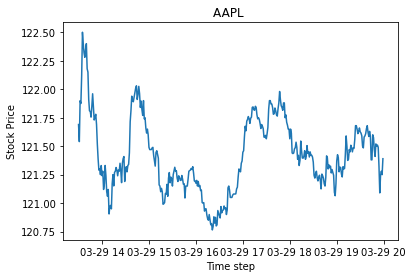

In [ ]:
aapl_df = pd.read_csv("Data/aapl.csv",index_col=0, parse_dates=True)
plt.plot(aapl_df['Close'])
plt.ylabel("Stock Price")
plt.xlabel("Time step")
plt.title("AAPL ")

In [ ]:
aapl_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2021-03-29 09:30:00-04:00,121.669998,121.699997,121.639999,121.690002,2489336,0,0
2021-03-29 09:31:00-04:00,121.705002,121.739998,121.250000,121.540001,496870,0,0
2021-03-29 09:32:00-04:00,121.529999,121.919998,121.500000,121.899101,527517,0,0
2021-03-29 09:33:00-04:00,121.863800,121.989998,121.830002,121.875000,534578,0,0
2021-03-29 09:34:00-04:00,122.023499,122.134003,122.000000,122.120003,482586,0,0
...,...,...,...,...,...,...,...
2021-03-29 15:55:00-04:00,121.330002,121.330002,121.089897,121.089897,549845,0,0
2021-03-29 15:56:00-04:00,121.089996,121.290001,121.080002,121.245003,393210,0,0
2021-03-29 15:57:00-04:00,121.239998,121.370003,121.230003,121.279999,355986,0,0


Text(0.5, 1.0, 'GOOG')

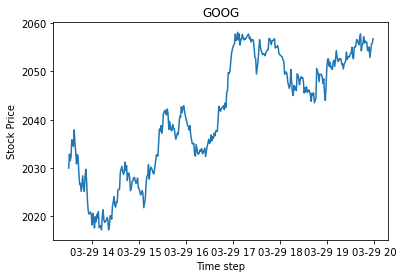

In [ ]:
goog_df = pd.read_csv("Data/goog.csv",index_col=0, parse_dates=True)
plt.plot(goog_df['Close'])
plt.ylabel("Stock Price")
plt.xlabel("Time step")
plt.title("GOOG")

## Agent

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import tensorflow_probability as tfp



class ActorCriticNetwork(keras.Model):
    def __init__(self, n_actions, fc1_dims=32, fc2_dims=16,
            name='actor_critic', chkpt_dir='Model/actor_critic'):
        super(ActorCriticNetwork, self).__init__()
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.model_name = name 
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name+'_ac')

        self.fc1 = Dense(self.fc1_dims, activation='tanh')
        self.fc2 = Dense(self.fc2_dims, activation='tanh')
        #self.v = Dense(6, activation=None)
        self.pi = Dense(n_actions, activation='softmax')

    def call(self, state):
        value = self.fc1(state)
        value = self.fc2(value)

        v = self.v(value)
        pi = self.pi(value)

        return v, pi

class Agent:
    def __init__(self, alpha=0.0005, gamma=0.99, n_actions=3,chkpt_dir='Model/actor_critic'):
        self.gamma = gamma
        self.n_actions = n_actions
        self.action = None
        self.action_space = [i for i in range(self.n_actions)]

        self.actor_critic = ActorCriticNetwork(n_actions=n_actions,chkpt_dir = chkpt_dir)

        self.actor_critic.compile(optimizer=Adam(learning_rate=alpha), run_eagerly=True)


    def choose_action(self, observation):
        state = tf.convert_to_tensor([observation])
        _, probs = self.actor_critic(state)

        action_probabilities = tfp.distributions.Categorical(probs=probs)
        action = action_probabilities.sample()
        log_prob = action_probabilities.log_prob(action)
        self.action = action

        return action.numpy()[0][0]

    def save_models(self):
        print('... saving models ...')
        self.actor_critic.save_weights(self.actor_critic.checkpoint_file)

    def load_models(self):
        print('... loading models ...')
        self.actor_critic.load_weights(self.actor_critic.checkpoint_file)
        
    def learn(self, state, reward, state_):
        state = tf.convert_to_tensor([state], dtype=tf.float32)
        state_ = tf.convert_to_tensor([state_], dtype=tf.float32)
        reward = tf.convert_to_tensor(reward, dtype=tf.float32) # not fed to NN
        with tf.GradientTape(persistent=True) as tape:
            state_value, probs = self.actor_critic(state)
            state_value_, _ = self.actor_critic(state_)
            state_value = tf.squeeze(state_value)
            state_value_ = tf.squeeze(state_value_)

            action_probs = tfp.distributions.Categorical(probs=probs)
            log_prob = action_probs.log_prob(self.action)

            delta = reward + self.gamma*state_value_ - state_value  #TD Error = (r + gamma*V_next) - V_curr
            actor_loss = -log_prob*delta
            critic_loss = delta**2
            total_loss = actor_loss + critic_loss

        gradient = tape.gradient(total_loss, self.actor_critic.trainable_variables)
        self.actor_critic.optimizer.apply_gradients(zip(
            gradient, self.actor_critic.trainable_variables))

## Env

In [ ]:
class Game(object):

    def __init__(self, df):
        self.df = df
        self.reset()
        
    def _update_state(self, action):
        
        '''Here we update our state'''
        self.curr_idx += 1
        self.curr_time = self.df.index[self.curr_idx]
        self.curr_price = self.df['Close'][self.curr_idx]
        self.curr_volume = self.df['Volume'][self.curr_idx]
        self.typical_price = (self.df['High'][self.curr_idx]+self.df['Low'][self.curr_idx]+self.df['Close'][self.curr_idx])/3
        #self.close_high = foo((self.df['High'][self.curr_idx]-self.df['Close'][self.curr_idx]), (self.df['High'][self.curr_idx]-self.df['Low'][self.curr_idx]))
        self.pseudo_vol = foo((self.df['High'][self.curr_idx]-self.df['Low'][self.curr_idx]), self.df['Open'][self.curr_idx])
        self.pnl = (-self.entry + self.curr_price)*self.position

        _k = list(map(float,str(self.curr_time.time()).split(':')[:2]))

        
        '''This is where we define our policy and update our position'''

        if action == 0:  # Hold
            if self.position == 0:
                self.entry = self.curr_price
                self.start_idx = self.curr_idx
            else:
                self.total_pnl = self.balance + self.entry*self.position + self.pnl
                self.reward = self.pnl
                
        
        elif action == 2: # Buy
            if self.position == -1:

                # one short round finished
                self.is_over = True
                self._get_reward() 
                self.total_pnl += self.pnl
                self.balance = self.total_pnl

                # new round
                self.position = 0  
                self.entry = self.curr_price
                self.start_idx = self.curr_idx
                
   
            elif self.position == 0:
                self.position = 1
                self.entry = self.curr_price
                self.start_idx = self.curr_idx
                self.is_over = False
                self.balance -= self.curr_price
                #self.total_pnl = self.balance + self.curr_price
            else: 
                self.total_pnl = self.balance + self.entry*self.position + self.pnl
                self.reward = self.pnl
            
        elif action == 1: # Sell
            if self.position == 1:
                # one long round finished
                self.is_over = True
                self._get_reward() 
                self.total_pnl += self.pnl
                self.balance = self.total_pnl

                # new round
                self.position = 0  
                self.entry = self.curr_price
                self.start_idx = self.curr_idx

            elif self.position == 0:
                self.position = -1
                self.entry = self.curr_price
                self.start_idx = self.curr_idx
                self.is_over = False
                self.balance += self.curr_price
            else:
                self.total_pnl = self.balance + self.entry*self.position + self.pnl
                self.reward = self.pnl

        self._assemble_state()

    def _assemble_state(self):
        self.state = np.array([])
        self.state = np.append(self.state,self.curr_price)
        self.state = np.append(self.state, self.typical_price)
        #self.state = np.append(self.state, self.close_high)
        self.state = np.append(self.state, self.pseudo_vol)
        self.state = np.append(self.state,self.curr_volume)
        self.state = np.append(self.state,self.position)
        #self.state = np.append(self.state,self._time_of_day)
        #self.state = np.append(self.state,self._day_of_week)
        self.state = (np.array(self.state)-np.mean(self.state))/np.std(self.state)
        

    def _get_reward(self):
        if self.position == 1 and self.is_over:
            pnl = (self.curr_price - self.entry)
            self.reward = pnl#-(self.curr_idx - self.start_idx)/1000.
        elif self.position == -1 and self.is_over:
            pnl = (-self.curr_price + self.entry)
            self.reward = pnl#-(self.curr_idx - self.start_idx)/1000.
        #print('entry:',self.entry,'exit:',self.curr_price,'pos:',self.position,'pnl:',pnl,self.reward)
        return self.reward
            
    def observe(self):
        return np.array([self.state])

    def act(self, action):
        self._update_state(action)
        reward = self.reward
        game_over = self.is_over
        return self.observe(), reward, game_over

    def reset(self):
        self.is_over = False
        self.pnl = 0
        self.total_pnl = 0
        self.balance = 0
        self.curr_idx = 0
        self.start_idx = self.curr_idx
        self.curr_time = self.df.index[self.curr_idx]
        self.curr_volume = self.df['Volume'][self.curr_idx]
        self.curr_price = self.df['Close'][self.curr_idx]
        self.entry = self.curr_price
        self.state = []
        self.position = 0
        self.reward = 0
        self.typical_price = (self.df['High'][self.curr_idx]+self.df['Low'][self.curr_idx]+self.df['Close'][self.curr_idx])/3
        self.close_high = (self.df['High'][self.curr_idx]-self.df['Close'][self.curr_idx])/(self.df['High'][self.curr_idx]-self.df['Low'][self.curr_idx])
        self.pseudo_vol = (self.df['High'][self.curr_idx]-self.df['Low'][self.curr_idx])/self.df['Open'][self.curr_idx]
        self._update_state(0)

def foo(x,y):
    try:
        return x/y
    except ZeroDivisionError:
        return 1

## Train_Test

In [ ]:
def Train(df,epoch,chkpt_dir, alpha = 0.0005):
    # parameters
    num_actions = 3 
    env = Game(df)
    agent = Agent(n_actions=num_actions, alpha = alpha, chkpt_dir = chkpt_dir)

    # Train

    pnls = []
    for e in range(epoch):
        loss = 0.
        env.reset()
        state = env.observe()
        for t in range(len(df)-2):
            # get next action
            state = env.observe()
            state = tf.convert_to_tensor(state)
            action = agent.choose_action(state)
            # apply action, get rewards and new state
            new_state, reward, game_over = env.act(action)
            agent.learn(state, reward, tf.convert_to_tensor(new_state)) 

        prt_str = ("Epoch {:03d} | pnl {:.2f}".format(e, env.total_pnl))

        print(prt_str)
        pnls.append(env.total_pnl)

    agent.save_models()
    fig =plt.figure(figsize = (8, 5))
    plt.plot(range(len(pnls)),pnls)
    plt.xlabel('Epoch', fontsize=10)
    plt.ylabel('P&L', fontsize=10)
    print("Average P&L is: ",sum(pnls)/len(pnls))   
    return 

In [ ]:
def Test(df, ticker, alpha, chkpt_dir):
    env = Game(df)
    agent = Agent(alpha = alpha, chkpt_dir = chkpt_dir)
    agent.load_models()
    env.reset()
    state = env.observe()
    pnls_record = [0]
    action_record = [0]
    for t in range(len(df)-2):
        # get next action
        state = env.observe()
        state = tf.convert_to_tensor(state)
        action = agent.choose_action(state)
        # apply action, get rewards and new state
        print('#', t, 
            'action', action, 
            'pos:' , env.position, 
            'reward:', "{:.3f}".format(env.reward), 
            'balance:', "{:.3f}".format(env.balance), 
            'pnl:', "{:.3f}".format(env.total_pnl))

        if (env.position == 1 and action == 2) or (env.position == -1 and action ==1):
            action_record.append(0)
        else:
            action_record.append(action)
        pnls_record.append(env.total_pnl)
        new_state, reward, game_over = env.act(action)
        agent.learn(state, reward, tf.convert_to_tensor(new_state))
    action_record.append(0)
    pnls_record.append(pnls_record[-1])
    action_record = np.array(action_record)
    df['buy_mask'] = (action_record == 2)
    df['sell_mask'] = (action_record == 1)
    df['pnls'] = pnls_record
    plot_result(df[:-2], ticker)
    print(env.total_pnl)


def plot_result(df, ticker):
    times = pd.date_range(df.index[0], df.index[-1],len(df))


    
    fig =plt.figure(figsize = (10,12))
    fig.add_subplot(211)
    plt.plot(times, df['Close'].values, linewidth=1, alpha = 0.8, label = ticker)

    
    #print(len(times[df['buy_mask']))
    #print(df['Close'][df['buy_mask'][:-2]].values[:-2])
    plt.scatter(times[df['buy_mask']], df['Close'][df['buy_mask']].values, label='Buy',
                    marker='*', alpha = 0.8, color='r',s = 25)
    plt.scatter(times[df['sell_mask']], df['Close'][df['sell_mask']].values, label='Sell',
                    marker='*', alpha = 0.8, color='g',s = 25)
    plt.xlabel('Date', fontsize=10)
    plt.ylabel('Price', fontsize=10)
    plt.legend()
    
    fig.add_subplot(212)
    plt.plot(times, df['pnls'].values,label = 'P&L')
    plt.xlabel('Date', fontsize=10)
    plt.ylabel('P&L', fontsize=10)

    #xfmt = mdates.DateFormatter('%m-%d-%y %H:%M')
    #fig.axes[0].xaxis.set_major_formatter(xfmt) 
    plt.legend()
    plt.show()
    
    

## Do Trading

... loading models ...
# 0 action 1 pos: 0 reward: 0.000 balance: 0.000 pnl: 0.000
# 1 action 1 pos: -1 reward: 0.000 balance: 121.899 pnl: 0.000
# 2 action 2 pos: -1 reward: 0.024 balance: 121.899 pnl: 0.024
# 3 action 1 pos: 0 reward: -0.221 balance: -0.197 pnl: -0.197
# 4 action 1 pos: -1 reward: -0.221 balance: 122.303 pnl: -0.197
# 5 action 2 pos: -1 reward: 0.100 balance: 122.303 pnl: -0.097
# 6 action 0 pos: 0 reward: 0.180 balance: 0.083 pnl: 0.083
# 7 action 0 pos: 0 reward: 0.180 balance: 0.083 pnl: 0.083
# 8 action 1 pos: 0 reward: 0.180 balance: 0.083 pnl: 0.083
# 9 action 2 pos: -1 reward: 0.180 balance: 122.483 pnl: 0.083
# 10 action 0 pos: 0 reward: 0.220 balance: 0.303 pnl: 0.303
# 11 action 0 pos: 0 reward: 0.220 balance: 0.303 pnl: 0.303
# 12 action 0 pos: 0 reward: 0.220 balance: 0.303 pnl: 0.303
# 13 action 2 pos: 0 reward: 0.220 balance: 0.303 pnl: 0.303
# 14 action 1 pos: 1 reward: 0.220 balance: -121.502 pnl: 0.303
# 15 action 1 pos: 0 reward: -0.050 balance: 0.2

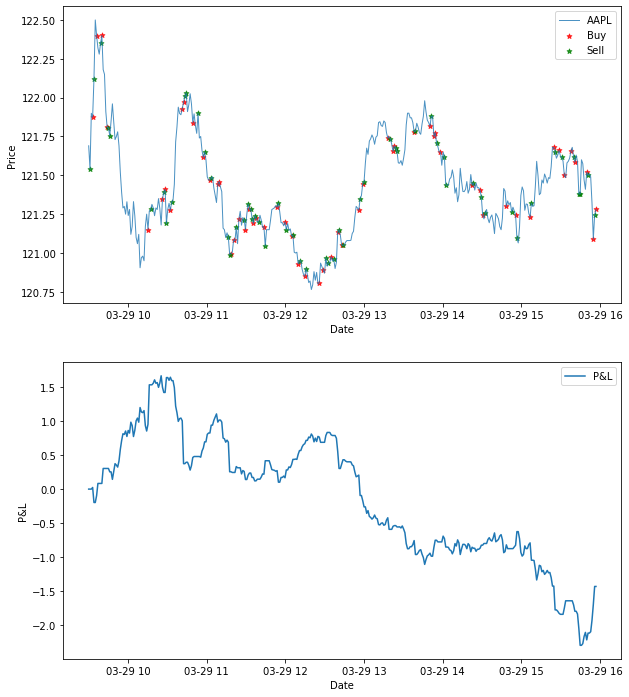

-1.40012359619152


In [ ]:
Test(aapl_df, 'AAPL', 0.003, 'Model/actor_critic_goog')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in double_scalars


... loading models ...
# 0 action 2 pos: 0 reward: 0.000 balance: 0.000 pnl: 0.000
# 1 action 2 pos: 1 reward: 0.000 balance: -2031.550 pnl: 0.000
# 2 action 2 pos: 1 reward: 0.780 balance: -2031.550 pnl: 0.780
# 3 action 2 pos: 1 reward: 4.325 balance: -2031.550 pnl: 4.325
# 4 action 2 pos: 1 reward: 4.160 balance: -2031.550 pnl: 4.160
# 5 action 2 pos: 1 reward: 2.970 balance: -2031.550 pnl: 2.970
# 6 action 2 pos: 1 reward: 6.370 balance: -2031.550 pnl: 6.370
# 7 action 2 pos: 1 reward: 3.711 balance: -2031.550 pnl: 3.711
# 8 action 2 pos: 1 reward: 1.800 balance: -2031.550 pnl: 1.800
# 9 action 2 pos: 1 reward: -0.700 balance: -2031.550 pnl: -0.700
# 10 action 2 pos: 1 reward: 1.250 balance: -2031.550 pnl: 1.250
# 11 action 2 pos: 1 reward: 0.910 balance: -2031.550 pnl: 0.910
# 12 action 2 pos: 1 reward: -2.550 balance: -2031.550 pnl: -2.550
# 13 action 2 pos: 1 reward: -4.853 balance: -2031.550 pnl: -4.853
# 14 action 2 pos: 1 reward: -4.830 balance: -2031.550 pnl: -4.830
# 15 act

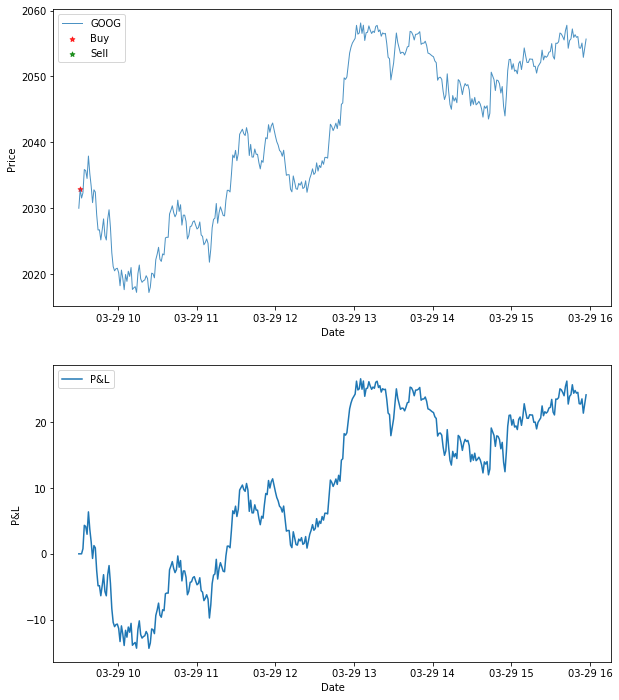

25.219970703125


In [ ]:
Test(goog_df, 'GOOG', 0.05, 'Model/actor_critic_goog')


In [ ]:
Train(aapl_df, 200,'Model/actor_critic')

Epoch 000 | pnl 0.49
Epoch 001 | pnl 0.69
Epoch 002 | pnl 1.16
Epoch 003 | pnl 1.20
Epoch 004 | pnl 3.04
Epoch 005 | pnl -0.47
Epoch 006 | pnl 1.43
Epoch 007 | pnl 0.95
Epoch 008 | pnl 0.16
Epoch 009 | pnl 0.46
Epoch 010 | pnl 1.77
Epoch 011 | pnl -0.31
Epoch 012 | pnl 1.06
Epoch 013 | pnl 1.10
Epoch 014 | pnl 1.66
Epoch 015 | pnl 0.56
Epoch 016 | pnl 3.86
Epoch 017 | pnl -2.67
Epoch 018 | pnl 0.30
Epoch 019 | pnl -1.09
Epoch 020 | pnl 0.35
Epoch 021 | pnl 1.49
Epoch 022 | pnl 0.96
Epoch 023 | pnl 0.31
Epoch 024 | pnl -3.07
Epoch 025 | pnl 0.07
Epoch 026 | pnl 3.86
Epoch 027 | pnl 1.27
Epoch 028 | pnl 2.93
Epoch 029 | pnl 2.62
Epoch 030 | pnl 1.02
Epoch 031 | pnl -0.99
Epoch 032 | pnl -1.98
Epoch 033 | pnl -1.70
Epoch 034 | pnl -1.08
Epoch 035 | pnl -1.86
Epoch 036 | pnl 2.21
Epoch 037 | pnl 1.00
Epoch 038 | pnl 0.32
Epoch 039 | pnl 0.03
Epoch 040 | pnl -1.72
Epoch 041 | pnl 2.07
Epoch 042 | pnl 1.48
Epoch 043 | pnl 0.61
Epoch 044 | pnl 2.50
Epoch 045 | pnl 2.05
Epoch 046 | pnl 1.72
Ep

KeyboardInterrupt: ignored

Epoch 000 | pnl -2.76
Epoch 001 | pnl -0.05
Epoch 002 | pnl -1.19
Epoch 003 | pnl -1.76
Epoch 004 | pnl 0.36
Epoch 005 | pnl -0.67
Epoch 006 | pnl 0.00
Epoch 007 | pnl -3.51
Epoch 008 | pnl 0.10
Epoch 009 | pnl 0.11
... saving models ...
Average P&L is:  -0.9363891601562286


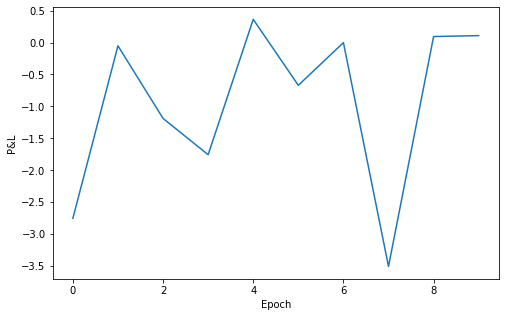

In [ ]:
Train(aapl_df, 10,'Model/actor_critic_appl', alpha = 0.005)

In [ ]:
Train(goog_df, 100,'Model/actor_critic_goog', alpha = 0.0003)